# Gaussian Naive Bayes - Heart Disease Classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying GNB
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### Var smoothing
The `var_smoothing` hyperparameter is added to the variances of each feature to ensure that no variance is zero. It's a smoothing parameter to avoid numerical errors. 


### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, but will ensure no data leakage and help reduce overfitting of the model. 

In [1]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [2]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='gdb', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `var_smoothing`: numbers spaced evenly on a log scale, from 0 to -9, generates 100 samples. 

In [3]:
# Define the parameter grid
param_grid = {
    'var_smoothing': np.logspace(0,-9,num=100)
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [4]:
# Define model
gnb = GaussianNB()

# Perform grid search
grid_search = GridSearchCV(gnb, param_grid, cv=10, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_6 = results.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_6 = top_6[['param_var_smoothing', 'mean_test_score', 'std_test_score']]

top_6

,param_var_smoothing,mean_test_score,std_test_score
6,0.284804,0.848559,0.051137
14,0.053367,0.846910,0.050251
5,0.351119,0.846674,0.052753
3,0.53367,0.846617,0.054912
4,0.432876,0.846617,0.054912
16,0.035112,0.846392,0.052511


We observe that there are only slight differences in both the mean and the standard deviation.

### Evaluating top 6 
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [5]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [6]:
# DataFrame with evaluation metric for each of the top 6 models
evaluation_results = pd.DataFrame(columns=['var_smoothing', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_6.iterrows():

    # Dict with params from the row
    params = {
        'var_smoothing': row['param_var_smoothing'],
    }

    # Fit the model with params
    model = GaussianNB(var_smoothing=params['var_smoothing'
                                            ])
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'var_smoothing': params['var_smoothing'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'])
evaluation_results

,var_smoothing,Recall,F1-score,Precision,Precision-recall AUC
5,0.035112,0.827,0.859,0.894,0.937
1,0.053367,0.835,0.864,0.895,0.937
0,0.284804,0.835,0.867,0.902,0.940
2,0.351119,0.842,0.872,0.903,0.941
4,0.432876,0.850,0.876,0.904,0.941
3,0.533670,0.857,0.877,0.898,0.942


From the results on the unseen data, we will further evaluate a model using `var_smoothing=0.432876`. This is due to the following considerations:
- It has the highets precision (0.904), in comparison `var_smoothing`=0.533670 has a precision=0.898.
- The F1-score for `var_smoothing` = 0.533670 is 0.877, which is slightly higher than the 0.876 for 0.432876. However, this difference is marginal (0.001) and might not be significant enough to warrant choosing the higher smoothing value if other metrics are more favorable. 
  

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for the `var_smoothing` hyperparameter. 

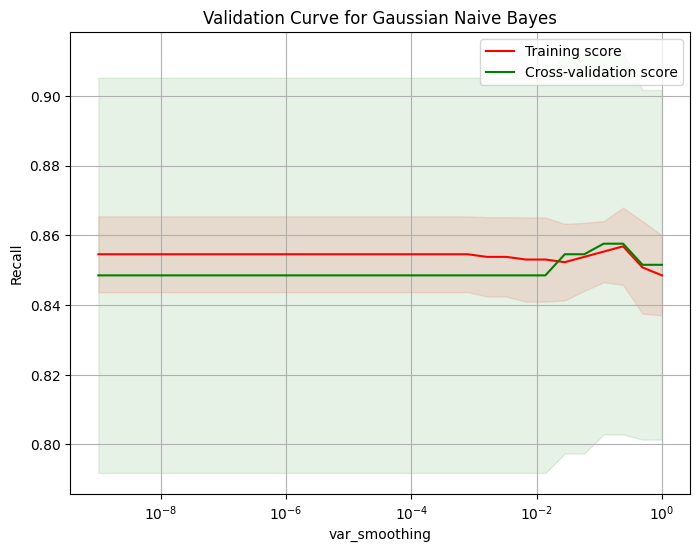

In [7]:
# Define parameter range for validation curve
param_range = np.logspace(-9,0,30)

# Calculate scores for validation curve
train_scores, test_scores = validation_curve(
    GaussianNB(),
    X_train, y_train, param_name="var_smoothing", 
    param_range=param_range,
    cv=5, scoring="recall", n_jobs=-1)

# Calculate mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training score", color="r")
plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.xscale('log')
plt.title("Validation Curve for Gaussian Naive Bayes")
plt.xlabel("var_smoothing")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.grid(True)
plt.show()


- At very low values (close to 10^-9), the model has very little smoothing applied to the variances of the features. This leads to a higher model complexity, capturing more details of the training data, which can increase the risk of overfitting. 
- Lower values of var_smoothing keep the model complexity higher, potentially capturing more noise in the training data, which could increase variance. However, in this case, both scores remain close and stable, indicating that overfitting is not a significant issue within the tested range.
- As `var_smoothing` increases, the variance smoothing effect becomes more pronounced. This effectively reduces model complexity by smoothing out the variances more aggressively, which can help prevent overfitting but may lead to underfitting if the smoothing is too strong. 
- Higher values of var_smoothing lead to increased bias, as the model becomes too simple to capture the underlying patterns in the data. This is reflected in the slight decline in recall scores as var_smoothing increases.